In [2]:
%matplotlib inline  
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visuvalization & plotting
import datetime  
from sklearn.linear_model import LogisticRegression #  Logistic Regression (aka logit) classifier in linear model
import joblib  #Joblib is a set of tools to provide lightweight pipelining in Python (Avoid computing twice the same thing)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
                                     # GridSearchCV - Implements a “fit” and a “score” method
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, make_scorer, accuracy_score, roc_curve, confusion_matrix, classification_report
                                    # Differnt metrics to evaluate the model 
import pandas_profiling as pp   # simple and fast exploratory data analysis of a Pandas Datafram

import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
def plot_roc_curve(y_train_actual, train_pred_prob, y_test_actual, test_pred_prob, *args):
    '''
    Generate the train & test roc curve
    '''

    AUC_Train = roc_auc_score(y_train_actual, train_pred_prob)
    AUC_Test = roc_auc_score(y_test_actual, test_pred_prob)

    if len(args) == 0:
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)

    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [4]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):
    '''
    Generates roc plot
    '''

    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

In [5]:
# Read-in the dataset
Insurance_Data = pd.read_csv('carInsurance_train.csv') 
print('Train Data Shape - ', Insurance_Data.shape)
Insurance_Data.head()

Train Data Shape -  (4000, 19)


Id  Age          Job  Marital Education  Default  Balance  HHInsurance  \
0   1   32   management   single  tertiary        0     1218            1   
1   2   32  blue-collar  married   primary        0     1156            1   
2   3   29   management   single  tertiary        0      637            1   
3   4   25      student   single   primary        0      373            1   
4   5   30   management  married  tertiary        0     2694            0   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        0     telephone              28              jan             2   
1        0           NaN              26              may             5   
2        0      cellular               3              jun             1   
3        0      cellular              11              may             2   
4        0      cellular               3              jun             1   

   DaysPassed  PrevAttempts  Outcome CallStart   CallEnd  CarInsurance  
0          -1             0      NaN  13:45:20  13:46:30             0  
1          -1             0      NaN  14:49:03  14:52:08             0  
2         119             1  failure  16:30:24  16:36:04             1  
3          -1             0      NaN  12:06:43  12:20:22             1  
4          -1             0      NaN  14:35:44  14:38:56             0

In [6]:
# What type of values are stored in the columns?
Insurance_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

In [7]:
pp.ProfileReport(Insurance_Data)

In [8]:
# Let's look at some statistical information about our dataframe.
Insurance_Data.describe()

Id          Age      Default       Balance  HHInsurance  \
count  4000.000000  4000.000000  4000.000000   4000.000000   4000.00000   
mean   2000.500000    41.214750     0.014500   1532.937250      0.49275   
std    1154.844867    11.550194     0.119555   3511.452489      0.50001   
min       1.000000    18.000000     0.000000  -3058.000000      0.00000   
25%    1000.750000    32.000000     0.000000    111.000000      0.00000   
50%    2000.500000    39.000000     0.000000    551.500000      0.00000   
75%    3000.250000    49.000000     0.000000   1619.000000      1.00000   
max    4000.000000    95.000000     1.000000  98417.000000      1.00000   

           CarLoan  LastContactDay  NoOfContacts   DaysPassed  PrevAttempts  \
count  4000.000000     4000.000000   4000.000000  4000.000000   4000.000000   
mean      0.133000       15.721250      2.607250    48.706500      0.717500   
std       0.339617        8.425307      3.064204   106.685385      2.078647   
min       0.000000        1.000000      1.000000    -1.000000      0.000000   
25%       0.000000        8.000000      1.000000    -1.000000      0.000000   
50%       0.000000       16.000000      2.000000    -1.000000      0.000000   
75%       0.000000       22.000000      3.000000    -1.000000      0.000000   
max       1.000000       31.000000     43.000000   854.000000     58.000000   

       CarInsurance  
count   4000.000000  
mean       0.401000  
std        0.490162  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [9]:
# This is how we can get summary for the categorical data
Insurance_Data.describe(include=np.object)

Job  Marital  Education Communication LastContactMonth  \
count         3981     4000       3831          3098             4000   
unique          11        3          3             2               12   
top     management  married  secondary      cellular              may   
freq           893     2304       1988          2831             1049   

        Outcome CallStart   CallEnd  
count       958      4000      4000  
unique        3      3777      3764  
top     failure  17:02:39  10:22:30  
freq        437         3         3

In [10]:
Target = 'CarInsurance'
pd.crosstab(Insurance_Data[Target], columns='N', normalize=True)

col_0             N
CarInsurance       
0             0.599
1             0.401

In [11]:
num_cols = Insurance_Data.select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.select_dtypes(exclude=[np.number]).columns.tolist()

In [12]:
# Lets drop columns which we will not use
num_cols = Insurance_Data.drop(['Id', 'CarInsurance'],axis=1).select_dtypes(include=[np.number]).columns.tolist()
non_num_cols = Insurance_Data.drop(['CallStart', 'CallEnd'],axis=1).select_dtypes(exclude=[np.number]).columns.tolist()

In [13]:
print('Numeric Columns \n', num_cols)
print('Non-Numeric Columns \n', non_num_cols)

Numeric Columns 
 ['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'LastContactDay', 'NoOfContacts', 'DaysPassed', 'PrevAttempts']
Non-Numeric Columns 
 ['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']


Age                    AxesSubplot(0.1,0.679412;0.363636x0.220588)
Balance           AxesSubplot(0.536364,0.679412;0.363636x0.220588)
DaysPassed             AxesSubplot(0.1,0.414706;0.363636x0.220588)
LastContactDay    AxesSubplot(0.536364,0.414706;0.363636x0.220588)
NoOfContacts               AxesSubplot(0.1,0.15;0.363636x0.220588)
PrevAttempts          AxesSubplot(0.536364,0.15;0.363636x0.220588)
dtype: object

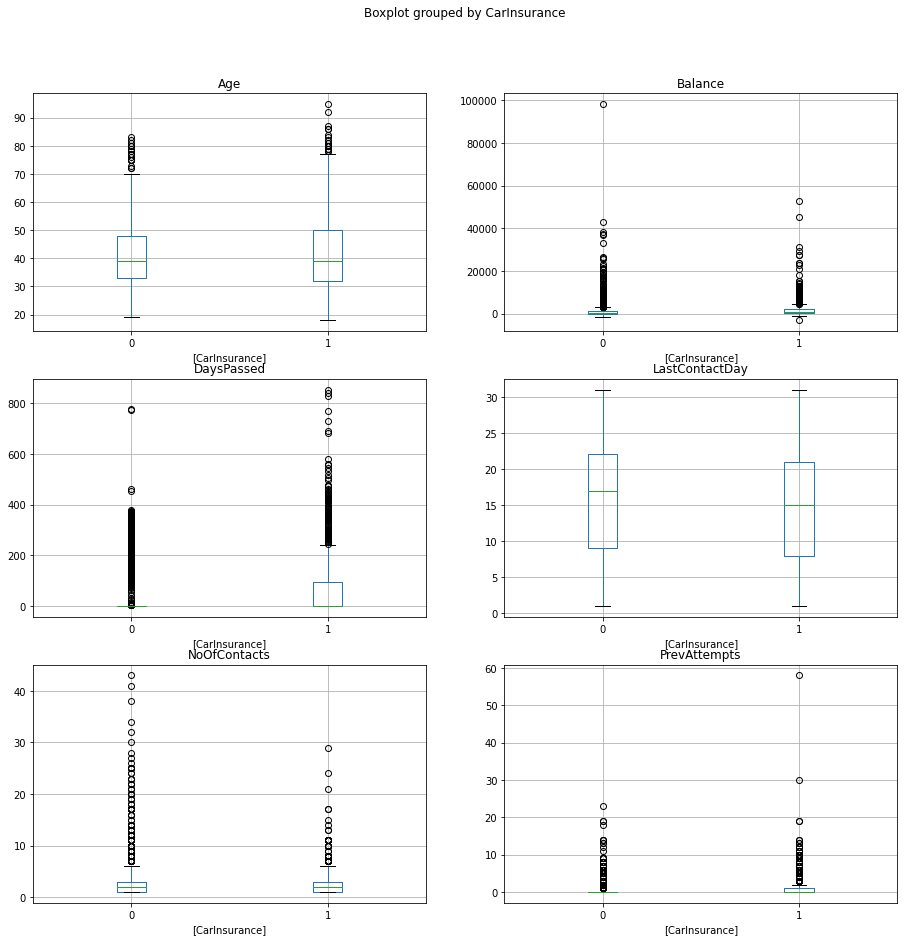

In [14]:
# Lets drop CarLoan, HHInsurance, Default from the numeric columns as these are dummies
num_cols_viz = ['DaysPassed', 'Age', 'NoOfContacts', 'PrevAttempts', 'LastContactDay', 'Balance']

fig, axes = plt.subplots(3,2,sharex=False,sharey=False, figsize=(15,15))
Insurance_Data.loc[:,[Target]+num_cols_viz].boxplot(by=Target, ax=axes, return_type='axes')

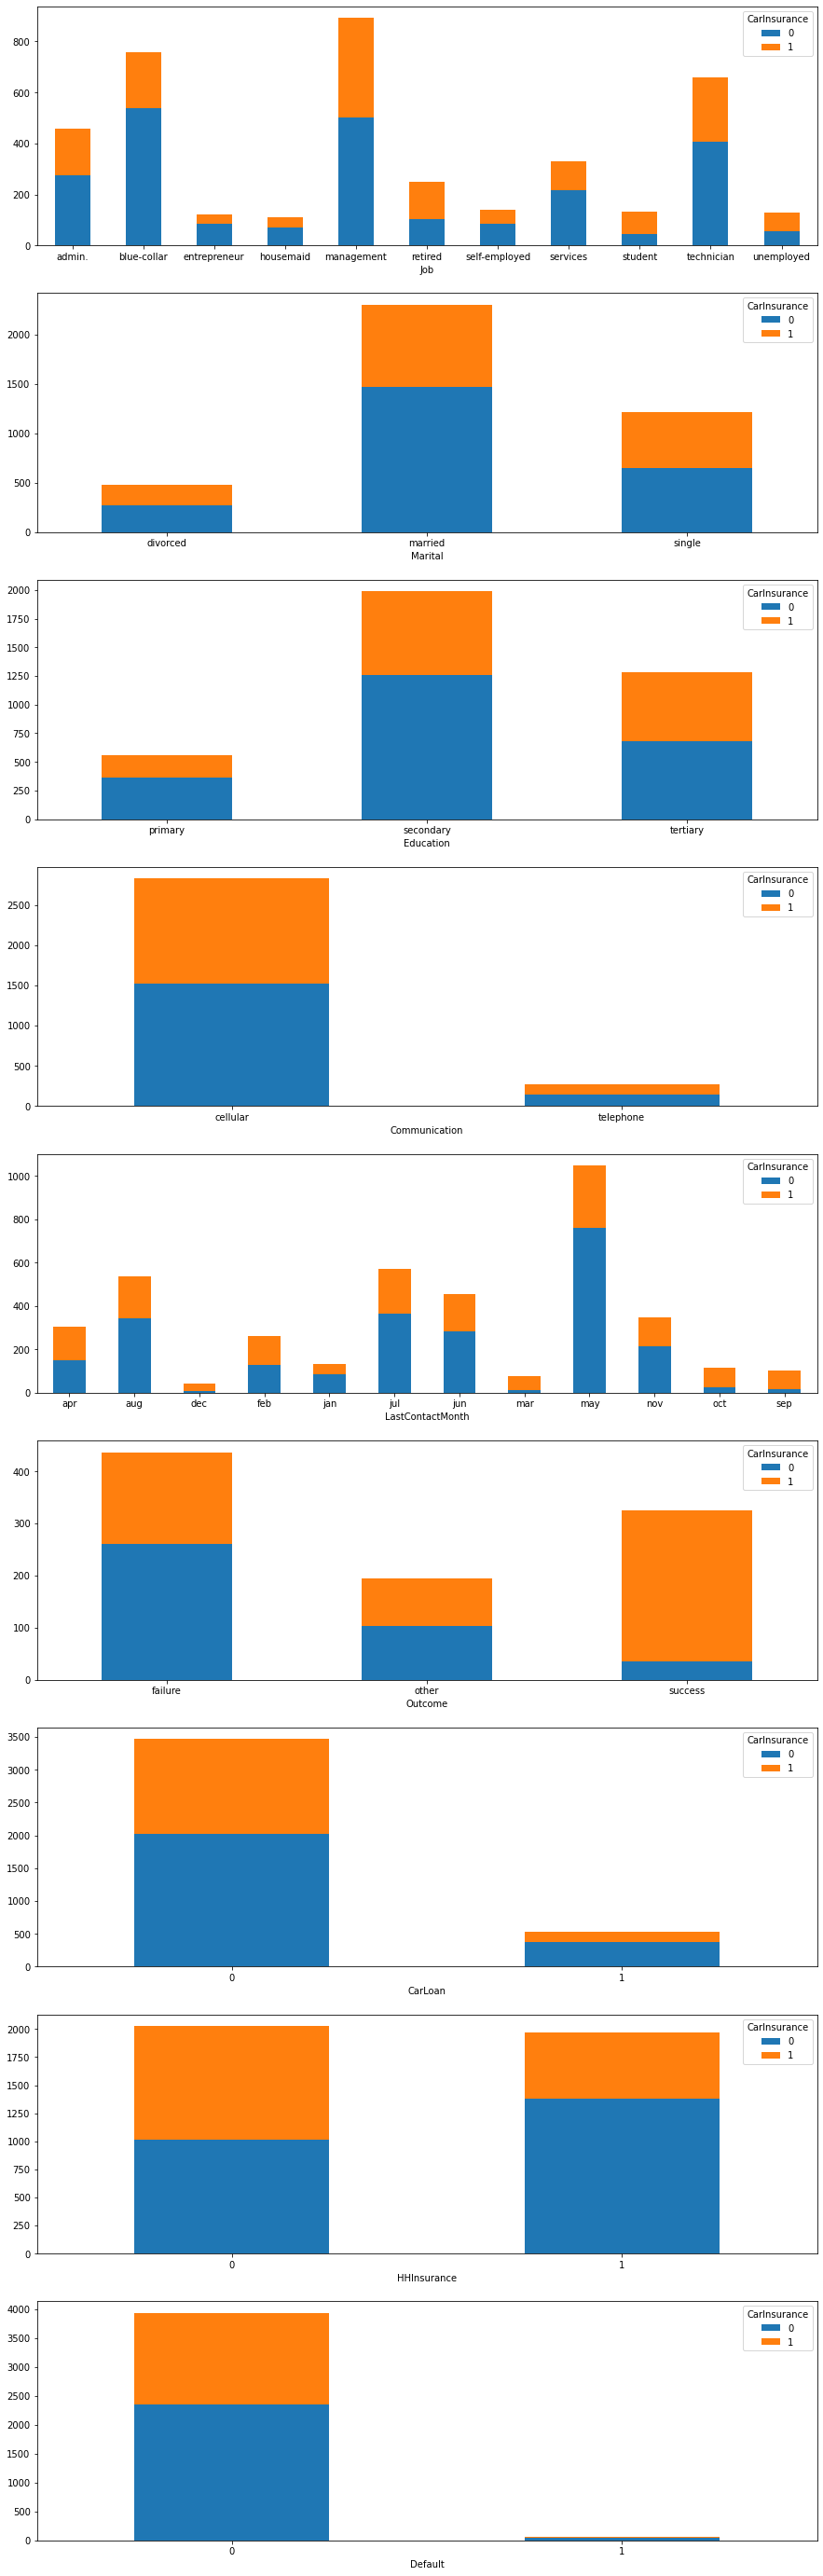

In [15]:
non_num_cols_viz = non_num_cols+['CarLoan', 'HHInsurance', 'Default']
fig, axes = plt.subplots(len(non_num_cols_viz),sharex=False,sharey=False, figsize=(15,50))
for i in range(len(non_num_cols_viz)):
    pd.crosstab(Insurance_Data[non_num_cols_viz[i]], Insurance_Data[Target]).plot(kind='bar', 
                                                                                  stacked=True, 
                                                                                  grid=False, 
                                                                                  ax=axes[i],
                                                                                  rot=0)

In [16]:
Insurance_Data.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

In [17]:
Insurance_Data_Org = Insurance_Data.copy()

In [18]:
Insurance_Data['Job'].value_counts(dropna=False)

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
NaN               19
Name: Job, dtype: int64

In [19]:
Insurance_Data['Job'] = Insurance_Data['Job'].fillna('None')
Insurance_Data['Job'].isnull().sum()

0

In [20]:
# Fill missing education with the most common education level by job type

# Create job-education level mode mapping
edu_mode=[]

# What are different Job Types
job_types = Insurance_Data.Job.value_counts().index

# Checking which job is most 
Insurance_Data['Job'].value_counts()

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
None              19
Name: Job, dtype: int64

In [21]:
# Now according to the job type we will crate a mapping where the job and mode of education is there.
# It means when there are many people in the managment job then most of them are in which education.
# We can find that in below mapping

for job in job_types:
    mode = Insurance_Data[Insurance_Data.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=Insurance_Data.Job.value_counts().index)

edu_map

management        tertiary
blue-collar      secondary
technician       secondary
admin.           secondary
services         secondary
retired          secondary
self-employed     tertiary
student          secondary
unemployed       secondary
entrepreneur      tertiary
housemaid          primary
None             secondary
dtype: object

In [22]:
# Apply the mapping to missing education obs. We will replace education now by jobs value
for j in job_types:
    Insurance_Data.loc[(Insurance_Data['Education'].isnull()) & (Insurance_Data['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]

# For those who are not getting mapped we will create a new category as None
Insurance_Data['Education'].fillna('None',inplace=True)

In [23]:
# Fill missing communication with none 
Insurance_Data['Communication'].value_counts(dropna=False)

cellular     2831
NaN           902
telephone     267
Name: Communication, dtype: int64

In [24]:
Insurance_Data['Communication'] = Insurance_Data['Communication'].fillna('None')

In [25]:
# Check for missing value in Outcome
Insurance_Data['Outcome'].value_counts(dropna=False)

NaN        3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [26]:
# Fill missing outcome as not in previous campaign, we are adding one category to Outcome
# We will add category if the value of DaysPassed is -1

Insurance_Data.loc[Insurance_Data['DaysPassed']==-1,'Outcome']='NoPrev'
Insurance_Data['Outcome'].value_counts(dropna=False)

NoPrev     3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64

In [27]:
# Check if we have any missing values left
Insurance_Data.isnull().sum()

Id                  0
Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
Communication       0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
Outcome             0
CallStart           0
CallEnd             0
CarInsurance        0
dtype: int64

In [28]:
Insurance_Data_num = Insurance_Data[num_cols+['Id', 'CarInsurance']]

In [29]:
# Categorical columns data
Insurance_Data_cat = Insurance_Data[non_num_cols]
non_num_cols

['Job', 'Marital', 'Education', 'Communication', 'LastContactMonth', 'Outcome']

In [30]:
# Create dummies
Insurance_Data_cat_dummies = pd.get_dummies(Insurance_Data_cat)
print(Insurance_Data_cat_dummies.shape)
Insurance_Data_cat_dummies.head()

(4000, 37)


Job_None  Job_admin.  Job_blue-collar  Job_entrepreneur  Job_housemaid  \
0         0           0                0                 0              0   
1         0           0                1                 0              0   
2         0           0                0                 0              0   
3         0           0                0                 0              0   
4         0           0                0                 0              0   

   Job_management  Job_retired  Job_self-employed  Job_services  Job_student  \
0               1            0                  0             0            0   
1               0            0                  0             0            0   
2               1            0                  0             0            0   
3               0            0                  0             0            1   
4               1            0                  0             0            0   

   Job_technician  Job_unemployed  Marital_divorced  Marital_married  \
0               0               0                 0                0   
1               0               0                 0                1   
2               0               0                 0                0   
3               0               0                 0                0   
4               0               0                 0                1   

   Marital_single  Education_primary  Education_secondary  Education_tertiary  \
0               1                  0                    0                   1   
1               0                  1                    0                   0   
2               1                  0                    0                   1   
3               1                  1                    0                   0   
4               0                  0                    0                   1   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   0                       0                        1   
1                   1                       0                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     1                     0                     0   
3                     0                     0                     1   
4                     1                     0                     0   

   LastContactMonth_nov  LastContactMonth_oct  LastContactMonth_sep  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0             

In [31]:
Insurance_Data_final = pd.concat([Insurance_Data_num, Insurance_Data_cat_dummies], axis=1)
print(Insurance_Data_final.shape)
Insurance_Data_final.head()

(4000, 48)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   32        0     1218            1        0              28             2   
1   32        0     1156            1        0              26             5   
2   29        0      637            1        0               3             1   
3   25        0      373            1        0              11             2   
4   30        0     2694            0        0               3             1   

   DaysPassed  PrevAttempts  Id  CarInsurance  Job_None  Job_admin.  \
0          -1             0   1             0         0           0   
1          -1             0   2             0         0           0   
2         119             1   3             1         0           0   
3          -1             0   4             1         0           0   
4          -1             0   5             0         0           0   

   Job_blue-collar  Job_entrepreneur  Job_housemaid  Job_management  \
0                0                 0              0               1   
1                1                 0              0               0   
2                0                 0              0               1   
3                0                 0              0               0   
4                0                 0              0               1   

   Job_retired  Job_self-employed  Job_services  Job_student  Job_technician  \
0            0                  0             0            0               0   
1            0                  0             0            0               0   
2            0                  0             0            0               0   
3            0                  0             0            1               0   
4            0                  0             0            0               0   

   Job_unemployed  Marital_divorced  Marital_married  Marital_single  \
0               0                 0                0               1   
1               0                 0                1               0   
2               0                 0                0               1   
3               0                 0                0               1   
4               0                 0                1               0   

   Education_primary  Education_secondary  Education_tertiary  \
0                  0                    0                   1   
1                  1                    0                   0   
2                  0                    0                   1   
3                  1                    0                   0   
4                  0                    0                   1   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   0                       0                        1   
1                   1                       0                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_

In [32]:
# Checking if there are missing values before we run model
Insurance_Data_final.isnull().sum(axis = 0)

Age                        0
Default                    0
Balance                    0
HHInsurance                0
CarLoan                    0
LastContactDay             0
NoOfContacts               0
DaysPassed                 0
PrevAttempts               0
Id                         0
CarInsurance               0
Job_None                   0
Job_admin.                 0
Job_blue-collar            0
Job_entrepreneur           0
Job_housemaid              0
Job_management             0
Job_retired                0
Job_self-employed          0
Job_services               0
Job_student                0
Job_technician             0
Job_unemployed             0
Marital_divorced           0
Marital_married            0
Marital_single             0
Education_primary          0
Education_secondary        0
Education_tertiary         0
Communication_None         0
Communication_cellular     0
Communication_telephone    0
LastContactMonth_apr       0
LastContactMonth_aug       0
LastContactMon

In [33]:
train_df = Insurance_Data_final.drop(['Id', 'CarInsurance'], axis=1)
train_label = Insurance_Data_final['CarInsurance']

In [34]:
#random_state is the seed used by the random number generator. It can be any integer.
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_label, train_size=0.7 , stratify=train_label, random_state=100)

In [35]:
print(y_train.shape[0])
print(np.sum(y_train))
print(y_test.shape[0])
print(np.sum(y_test))

2800
1123
1200
481


In [36]:
print('Train shape - ', X_train.shape)
print('Test shape  - ', X_test.shape)

Train shape -  (2800, 46)
Test shape  -  (1200, 46)


In [37]:
# Define Model parameters to tune
model_parameters = {
        'penalty':['l2'],
        'C': [1,10,100,1000],
        'class_weight': ['balanced', None]
    }

In [38]:
# Gridsearch the parameters to find the best parameters. Using L2 penalty
model = LogisticRegression(random_state=1)

gscv = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1')

gscv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [39]:
print('The best parameter are -', gscv.best_params_)

The best parameter are - {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}


In [40]:
print(gscv.best_score_)
print(gscv.best_estimator_)
print(gscv.scorer_)

0.6136746791297839
LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
make_scorer(f1_score, average=binary)


In [41]:
# Re-fit the model with the best parameters
final_mod = LogisticRegression(**gscv.best_params_)
final_mod.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
print('AUC on test by final_mod =', roc_auc_score(y_true=y_test,
                                                        y_score=final_mod.predict_proba(X_test)[:, 1]))

AUC on test by final_mod = 0.7376958642605373


In [43]:
print('AUC on test by gscv =', roc_auc_score(y_true=y_test,
                                                        y_score=gscv.predict_proba(X_test)[:, 1]))

AUC on test by gscv = 0.7372968346542755


In [44]:
# View the model coefficients
list(zip(X_train.columns, final_mod.coef_[0]))

[('Age', 0.00640317183799564),
 ('Default', -0.06392554690342804),
 ('Balance', 1.0464603712179227e-05),
 ('HHInsurance', -0.5017249649640936),
 ('CarLoan', -0.2997891025429285),
 ('LastContactDay', -0.006949281568805407),
 ('NoOfContacts', -0.06218336212210046),
 ('DaysPassed', 0.0010072861284512451),
 ('PrevAttempts', 0.007216816723690952),
 ('Job_None', 0.04759372554519395),
 ('Job_admin.', 0.11278148651661621),
 ('Job_blue-collar', -0.19301435018172247),
 ('Job_entrepreneur', -0.5355615827698157),
 ('Job_housemaid', -0.2111040544206094),
 ('Job_management', -0.03741850328325869),
 ('Job_retired', 0.1757997122619504),
 ('Job_self-employed', -0.3031878434234494),
 ('Job_services', -0.05235790285849102),
 ('Job_student', 0.6867745580292569),
 ('Job_technician', 0.04722074585492718),
 ('Job_unemployed', 0.4761525449890033),
 ('Marital_divorced', 0.1780742177800923),
 ('Marital_married', -0.15169355566928408),
 ('Marital_single', 0.1872978741487795),
 ('Education_primary', -0.0014862835

In [45]:
# Prediction
train_pred = final_mod.predict(X_train)
test_pred = final_mod.predict(X_test)

In [46]:
print('Classification report for train data is : \n',
      classification_report(y_train, train_pred))
print('Classification report for test data is : \n',
      classification_report(y_test, test_pred))

Classification report for train data is : 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      1677
           1       0.64      0.64      0.64      1123

    accuracy                           0.71      2800
   macro avg       0.70      0.70      0.70      2800
weighted avg       0.71      0.71      0.71      2800

Classification report for test data is : 
               precision    recall  f1-score   support

           0       0.74      0.77      0.75       719
           1       0.63      0.60      0.62       481

    accuracy                           0.70      1200
   macro avg       0.69      0.69      0.69      1200
weighted avg       0.70      0.70      0.70      1200



In [47]:
# Save the variables used in the model as it will be required in future for new datasets prediction
final_mod.variables = X_train.columns

In [48]:
joblib.dump(final_mod, 'best_model.joblib')

['best_model.joblib']

Train AUC =  0.7606249976769144
Test AUC =  0.7376958642605373


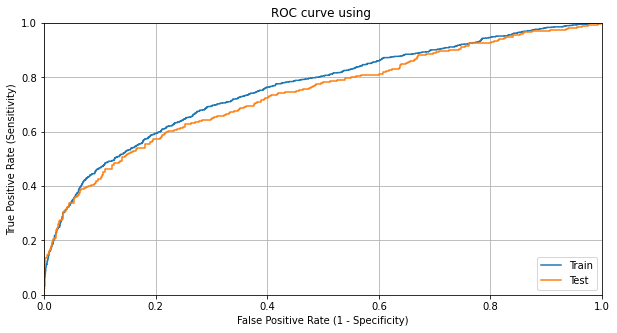

In [49]:
# Generate ROC
plt.subplots(figsize=(10, 5))
train_prob = final_mod.predict_proba(X_train)[:, 1]
test_prob = final_mod.predict_proba(X_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)

In [50]:
coefs = pd.DataFrame(list(final_mod.coef_.ravel()),
                        list(X_train.columns)).reset_index()
coefs.columns = ['feature', 'coefficient']
coefs = coefs.sort_values(by='coefficient', ascending=False)
coefs

feature  coefficient
45          Outcome_success     1.662751
41     LastContactMonth_sep     0.818688
40     LastContactMonth_oct     0.692544
18              Job_student     0.686775
37     LastContactMonth_mar     0.682440
28   Communication_cellular     0.592205
32     LastContactMonth_dec     0.487324
20           Job_unemployed     0.476153
36     LastContactMonth_jun     0.341673
29  Communication_telephone     0.298318
26       Education_tertiary     0.291727
23           Marital_single     0.187298
21         Marital_divorced     0.178074
15              Job_retired     0.175800
10               Job_admin.     0.112781
9                  Job_None     0.047594
19           Job_technician     0.047221
30     LastContactMonth_apr     0.017210
8              PrevAttempts     0.007217
0                       Age     0.006403
7                DaysPassed     0.001007
2                   Balance     0.000010
24        Education_primary    -0.001486
5            LastContactDay    -0.006949
14           Job_management    -0.037419
17             Job_services    -0.052358
6              NoOfContacts    -0.062183
1                   Default    -0.063926
25      Education_secondary    -0.076562
22          Marital_married    -0.151694
11          Job_blue-collar    -0.193014
38     LastContactMonth_may    -0.204663
13            Job_housemaid    -0.211104
33     LastContactMonth_feb    -0.216961
42           Outcome_NoPrev    -0.281459
4                   CarLoan    -0.299789
16        Job_self-employed    -0.303188
35     LastContactMonth_jul    -0.371884
39     LastContactMonth_nov    -0.456318
3               HHInsurance    -0.501725
12         Job_entrepreneur    -0.535562
43          Outcome_failure    -0.579437
44            Outcome_other    -0.588177
27       Communication_None    -0.676845
34     LastContactMonth_jan    -0.769706
31     LastContactMonth_aug    -0.806669

<AxesSubplot:ylabel='feature'>

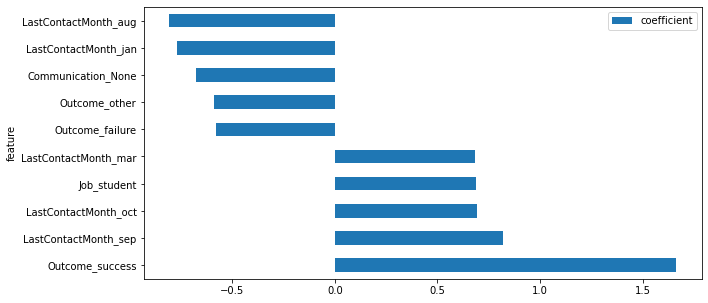

In [51]:
# Select top 5 features to display
top_features = coefs[:5]
top_features = top_features.sort_values(by='coefficient', ascending=False)

# Select bottom 5 features to display
bottom_features = coefs[-5:]
bottom_features = bottom_features.sort_values(
    by='coefficient', ascending=False)

# Display 10 most important features
pd.concat([top_features, bottom_features], axis=0).plot(
    kind='barh', figsize=(10, 5), x='feature')

In [52]:
# Load the saved model

best_model = joblib.load('best_model.joblib')

In [53]:
# Load the test data
Insurance_test = pd.read_csv('carInsurance_test.csv')
print('Test Data Shape  - ', Insurance_test.shape)
Insurance_test.head()

Test Data Shape  -  (1000, 19)


Id  Age         Job  Marital  Education  Default  Balance  HHInsurance  \
0  4001   25      admin.   single  secondary        0        1            1   
1  4002   40  management  married   tertiary        0        0            1   
2  4003   44  management   single   tertiary        0    -1313            1   
3  4004   27    services   single  secondary        0     6279            1   
4  4005   53  technician  married  secondary        0     7984            1   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        1           NaN              12              may            12   
1        1      cellular              24              jul             1   
2        1      cellular              15              may            10   
3        0      cellular               9              nov             1   
4        0      cellular               2              feb             1   

   DaysPassed  PrevAttempts Outcome CallStart   CallEnd  CarInsurance  
0          -1             0     NaN  17:17:42  17:18:06           NaN  
1          -1             0     NaN  09:13:44  09:14:37           NaN  
2          -1             0     NaN  15:24:07  15:25:51           NaN  
3          -1             0     NaN  09:43:44  09:48:01           NaN  
4          -1             0     NaN  16:31:51  16:34:22           NaN

In [54]:
# Handle missing values on the test data
# The function takes the dataframe and does the same preprocessing that was done for train data

def handle_missing_values(df):
    #Job 
    df['Job'] = df['Job'].fillna('None')
    
    #Education
    # Apply the mapping to missing eductaion obs. We will replace education now by jobs value
    for j in job_types:
        df.loc[(df['Education'].isnull()) & (df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]

    # For those who are not getting mapped we will create a new category as None
    df['Education'] = df['Education'].fillna('None')
    
    #Communication
    df['Communication'] = df['Communication'].fillna('None')
    
    #Outcome
    df.loc[df['DaysPassed']==-1,'Outcome']='NoPrev'
    
    return df

In [55]:
Insurance_test_Org = Insurance_test.copy()

In [56]:
# Handle the missing values the same we had done for Train
Insurance_test = handle_missing_values(Insurance_test)

In [57]:
Insurance_test.isnull().sum()

Id                     0
Age                    0
Job                    0
Marital                0
Education              0
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication          0
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome                0
CallStart              0
CallEnd                0
CarInsurance        1000
dtype: int64

In [58]:
# Convert Categorical to dummies
dummy_cols = pd.get_dummies(Insurance_test[non_num_cols])
dummy_cols.head()

Job_None  Job_admin.  Job_blue-collar  Job_entrepreneur  Job_housemaid  \
0         0           1                0                 0              0   
1         0           0                0                 0              0   
2         0           0                0                 0              0   
3         0           0                0                 0              0   
4         0           0                0                 0              0   

   Job_management  Job_retired  Job_self-employed  Job_services  Job_student  \
0               0            0                  0             0            0   
1               1            0                  0             0            0   
2               1            0                  0             0            0   
3               0            0                  0             1            0   
4               0            0                  0             0            0   

   Job_technician  Job_unemployed  Marital_divorced  Marital_married  \
0               0               0                 0                0   
1               0               0                 0                1   
2               0               0                 0                0   
3               0               0                 0                0   
4               1               0                 0                1   

   Marital_single  Education_primary  Education_secondary  Education_tertiary  \
0               1                  0                    1                   0   
1               0                  0                    0                   1   
2               1                  0                    0                   1   
3               1                  0                    1                   0   
4               0                  0                    1                   0   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   1                       0                        0   
1                   0                       1                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_nov  LastContactMonth_oct  LastContactMonth_sep  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     1                     0                     0   
4                     0                     0             

In [59]:
# Append the columns
new_data = pd.concat([Insurance_test[num_cols], dummy_cols], axis=1)
print(new_data.shape)
new_data.head()

(1000, 46)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  Job_admin.  Job_blue-collar  \
0          -1             0         0           1                0   
1          -1             0         0           0                0   
2          -1             0         0           0                0   
3          -1             0         0           0                0   
4          -1             0         0           0                0   

   Job_entrepreneur  Job_housemaid  Job_management  Job_retired  \
0                 0              0               0            0   
1                 0              0               1            0   
2                 0              0               1            0   
3                 0              0               0            0   
4                 0              0               0            0   

   Job_self-employed  Job_services  Job_student  Job_technician  \
0                  0             0            0               0   
1                  0             0            0               0   
2                  0             0            0               0   
3                  0             1            0               0   
4                  0             0            0               1   

   Job_unemployed  Marital_divorced  Marital_married  Marital_single  \
0               0                 0                0               1   
1               0                 0                1               0   
2               0                 0                0               1   
3               0                 0                0               1   
4               0                 0                1               0   

   Education_primary  Education_secondary  Education_tertiary  \
0                  0                    1                   0   
1                  0                    0                   1   
2                  0                    0                   1   
3                  0                    1                   0   
4                  0                    1                   0   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   1                       0                        0   
1                   0                       1                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     1   
1                     0       

In [60]:
# Check if all the variables of train are present in test
# Variables in model
best_model.variables

Index(['Age', 'Default', 'Balance', 'HHInsurance', 'CarLoan', 'LastContactDay',
       'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'Job_None', 'Job_admin.',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed', 'Marital_divorced',
       'Marital_married', 'Marital_single', 'Education_primary',
       'Education_secondary', 'Education_tertiary', 'Communication_None',
       'Communication_cellular', 'Communication_telephone',
       'LastContactMonth_apr', 'LastContactMonth_aug', 'LastContactMonth_dec',
       'LastContactMonth_feb', 'LastContactMonth_jan', 'LastContactMonth_jul',
       'LastContactMonth_jun', 'LastContactMonth_mar', 'LastContactMonth_may',
       'LastContactMonth_nov', 'LastContactMonth_oct', 'LastContactMonth_sep',
       'Outcome_NoPrev', 'Outcome_failure', 'Outcome_other',
       'Outcome_success'],
      dtype='object'

In [61]:
# Variables missing in test data. This happens sometimes because of some categories not present in the new data
vars_missing = list(set(best_model.variables) - set(new_data.columns))
vars_missing

[]

In [62]:
# Create the missing columns in the dataset and fill them with 0
# This will create columns bonly if there are missing values
for i in vars_missing:
    new_data[i] = 0
    
print(new_data.shape)
new_data.head()

(1000, 46)


Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  Job_admin.  Job_blue-collar  \
0          -1             0         0           1                0   
1          -1             0         0           0                0   
2          -1             0         0           0                0   
3          -1             0         0           0                0   
4          -1             0         0           0                0   

   Job_entrepreneur  Job_housemaid  Job_management  Job_retired  \
0                 0              0               0            0   
1                 0              0               1            0   
2                 0              0               1            0   
3                 0              0               0            0   
4                 0              0               0            0   

   Job_self-employed  Job_services  Job_student  Job_technician  \
0                  0             0            0               0   
1                  0             0            0               0   
2                  0             0            0               0   
3                  0             1            0               0   
4                  0             0            0               1   

   Job_unemployed  Marital_divorced  Marital_married  Marital_single  \
0               0                 0                0               1   
1               0                 0                1               0   
2               0                 0                0               1   
3               0                 0                0               1   
4               0                 0                1               0   

   Education_primary  Education_secondary  Education_tertiary  \
0                  0                    1                   0   
1                  0                    0                   1   
2                  0                    0                   1   
3                  0                    1                   0   
4                  0                    1                   0   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   1                       0                        0   
1                   0                       1                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     1   
1                     0       

In [63]:
# Get the new dataset in the same order of the variables used in train
new_data_final = new_data[best_model.variables]
new_data.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  Job_admin.  Job_blue-collar  \
0          -1             0         0           1                0   
1          -1             0         0           0                0   
2          -1             0         0           0                0   
3          -1             0         0           0                0   
4          -1             0         0           0                0   

   Job_entrepreneur  Job_housemaid  Job_management  Job_retired  \
0                 0              0               0            0   
1                 0              0               1            0   
2                 0              0               1            0   
3                 0              0               0            0   
4                 0              0               0            0   

   Job_self-employed  Job_services  Job_student  Job_technician  \
0                  0             0            0               0   
1                  0             0            0               0   
2                  0             0            0               0   
3                  0             1            0               0   
4                  0             0            0               1   

   Job_unemployed  Marital_divorced  Marital_married  Marital_single  \
0               0                 0                0               1   
1               0                 0                1               0   
2               0                 0                0               1   
3               0                 0                0               1   
4               0                 0                1               0   

   Education_primary  Education_secondary  Education_tertiary  \
0                  0                    1                   0   
1                  0                    0                   1   
2                  0                    0                   1   
3                  0                    1                   0   
4                  0                    1                   0   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   1                       0                        0   
1                   0                       1                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     1   
1                     0       

In [64]:
# Predict on the new data
new_data_final['Predicted'] = best_model.predict(new_data_final)
new_data_final.head()

Age  Default  Balance  HHInsurance  CarLoan  LastContactDay  NoOfContacts  \
0   25        0        1            1        1              12            12   
1   40        0        0            1        1              24             1   
2   44        0    -1313            1        1              15            10   
3   27        0     6279            1        0               9             1   
4   53        0     7984            1        0               2             1   

   DaysPassed  PrevAttempts  Job_None  Job_admin.  Job_blue-collar  \
0          -1             0         0           1                0   
1          -1             0         0           0                0   
2          -1             0         0           0                0   
3          -1             0         0           0                0   
4          -1             0         0           0                0   

   Job_entrepreneur  Job_housemaid  Job_management  Job_retired  \
0                 0              0               0            0   
1                 0              0               1            0   
2                 0              0               1            0   
3                 0              0               0            0   
4                 0              0               0            0   

   Job_self-employed  Job_services  Job_student  Job_technician  \
0                  0             0            0               0   
1                  0             0            0               0   
2                  0             0            0               0   
3                  0             1            0               0   
4                  0             0            0               1   

   Job_unemployed  Marital_divorced  Marital_married  Marital_single  \
0               0                 0                0               1   
1               0                 0                1               0   
2               0                 0                0               1   
3               0                 0                0               1   
4               0                 0                1               0   

   Education_primary  Education_secondary  Education_tertiary  \
0                  0                    1                   0   
1                  0                    0                   1   
2                  0                    0                   1   
3                  0                    1                   0   
4                  0                    1                   0   

   Communication_None  Communication_cellular  Communication_telephone  \
0                   1                       0                        0   
1                   0                       1                        0   
2                   0                       1                        0   
3                   0                       1                        0   
4                   0                       1                        0   

   LastContactMonth_apr  LastContactMonth_aug  LastContactMonth_dec  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   LastContactMonth_feb  LastContactMonth_jan  LastContactMonth_jul  \
0                     0                     0                     0   
1                     0                     0                     1   
2                     0                     0                     0   
3                     0                     0                     0   
4                     1                     0                     0   

   LastContactMonth_jun  LastContactMonth_mar  LastContactMonth_may  \
0                     0                     0                     1   
1                     0       

In [65]:
# Export the results
new_data_final.to_csv('Predicted.csv', index=False)